In [ ]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib notebook

# Load MNIST dataset

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Normalize values to [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Encoder and decoder architecture
We use a convolutional architecture for both the encoder and the decoder. For the variational version, we simply add another output tensor for the covariance matrix.

- Note1: the decoder does not need to be modified, since it only takes a sample as input.
- Note2: predicting a full covariance matrix has a cost of O(D^2) (where D is the number of dimensions). Although in this toy example we only use two dimensions for visualization purposes, in practice tens or hundreds of dimensions are used, which leads to an unreasonable number of model parameters. For this reason, the common practice is to predict a diagonal covariance matrix, which can be compactly represented as a vector.
- Note3: to enforce $\sigma > 0$, we predict $logvar = \log \sigma^2$ which is defined everywhere, and compute $\sigma = \exp(logvar/2)$ when needed. This representation also fits well with the expression for the KL divergence (see later).

In [3]:
def construct_encoder(n_dimensions=2, variational=False):
    # Input: 28x28 images with only 1 color channel (since MNIST is black and white)
    X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    
    # Two convolutional layers
    conv1 = tf.layers.conv2d(X, filters=32, kernel_size=5, strides=(2, 2), padding='same', activation=tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=3, strides=(2, 2), padding='same', activation=tf.nn.relu)
    
    # Two fully-connected layers
    flattened = tf.layers.flatten(conv2)
    dense1 = tf.layers.dense(flattened, units=128, activation=tf.nn.relu)
    Z_mu = tf.layers.dense(dense1, units=n_dimensions) # No activation
    
    if variational:
        # Variational autoencoder with soft embeddings
        # To avoid introducing a constraint sigma > 0, we return log(sigma^2) instead
        Z_logvar = tf.layers.dense(dense1, units=n_dimensions) # No activation
        
        # Return input placeholder X and output functions Z_mu and Z_logvar
        return X, Z_mu, Z_logvar
    else:
        # Traditional non-linear autoencoder with point embeddings
        # Return input placeholder X and output function Z
        return X, Z_mu

In [4]:
def construct_decoder(Z, n_dimensions=2):
    # Two fully-connected layers
    dense1 = tf.layers.dense(Z, units=128, activation=tf.nn.relu)
    dense2 = tf.layers.dense(dense1, units=7*7*32, activation=tf.nn.relu)
    
    # Two deconvolutional layers (i.e. transposed convolutions)
    reshaped = tf.reshape(dense2, [-1, 7, 7, 32])
    deconv1 = tf.layers.conv2d_transpose(reshaped, filters=32, kernel_size=3, strides=(2, 2),
                                         padding='same', activation=tf.nn.relu)
    X_reconstruction = tf.layers.conv2d_transpose(deconv1, filters=1, kernel_size=5, strides=(2, 2),
                                                  padding='same') # No activation
    
    return X_reconstruction

In [5]:
def log_likelihood_loss(X_reconstruction, X_target):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=X_reconstruction, labels=X_target)
    
    # Sum across channels and pixels, average across batch dimension
    return tf.reduce_mean(tf.reduce_sum(loss, axis=[1, 2, 3]), axis=0)

In [6]:
tf.reset_default_graph()

X, Z = construct_encoder(variational=False)
X_recon = construct_decoder(Z)

bce_loss = log_likelihood_loss(X_recon, X)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(bce_loss)

init = tf.global_variables_initializer()

In [7]:
session = tf.Session()
session.run(init)

batch_size = 256

# Summary for TensorBoard
summary_writer = tf.summary.FileWriter('ex09/ae', session.graph)
tf.summary.scalar(name='bce_loss', tensor=bce_loss)
summary_op = tf.summary.merge_all()

iteration = 0
for epoch in range(50):
    perm_indices = np.random.permutation(X_train.shape[0])
    
    index = 0
    
    total_loss = 0
    N_batches = 0
    while index < X_train.shape[0]:
        X_batch = X_train[index:index+batch_size]
        index += batch_size
        
        _, loss_value, summary_str = session.run([train_op, bce_loss, summary_op],
                                                  feed_dict={X: X_batch[:, :, :, np.newaxis]})
        summary_writer.add_summary(summary_str, iteration)
        
        total_loss += loss_value
        N_batches += 1
        iteration += 1
        
    total_loss /= N_batches
    
    print('[Epoch {}] bce_loss: {}'.format(epoch+1, total_loss))

[Epoch 1] bce_loss: 221.54629140001663
[Epoch 2] bce_loss: 178.3059611219041
[Epoch 3] bce_loss: 167.68441136136968
[Epoch 4] bce_loss: 161.06906030533162
[Epoch 5] bce_loss: 156.6397307050989
[Epoch 6] bce_loss: 153.73384899382896
[Epoch 7] bce_loss: 151.62373637747257
[Epoch 8] bce_loss: 150.0122393019656
[Epoch 9] bce_loss: 148.7014028995595
[Epoch 10] bce_loss: 147.61702140645778
[Epoch 11] bce_loss: 146.7153173568401
[Epoch 12] bce_loss: 145.8553564193401
[Epoch 13] bce_loss: 145.10304662826212
[Epoch 14] bce_loss: 144.48417462288066
[Epoch 15] bce_loss: 143.9045612741024
[Epoch 16] bce_loss: 143.37819460605053
[Epoch 17] bce_loss: 142.89262610902176
[Epoch 18] bce_loss: 142.44591798173622
[Epoch 19] bce_loss: 142.0386977175449
[Epoch 20] bce_loss: 141.65966595588847
[Epoch 21] bce_loss: 141.3136696673454
[Epoch 22] bce_loss: 141.00468353920795
[Epoch 23] bce_loss: 140.73870031478558
[Epoch 24] bce_loss: 140.4560048204787
[Epoch 25] bce_loss: 140.15185566354305
[Epoch 26] bce_loss

# Sample reconstruction from the test set (AE)

In [8]:
X_sample = X_test[np.random.choice(X_test.shape[0], size=16*16)]
recon_viz, = session.run([tf.sigmoid(X_recon)], feed_dict={X: X_sample[:, :, :, np.newaxis]})

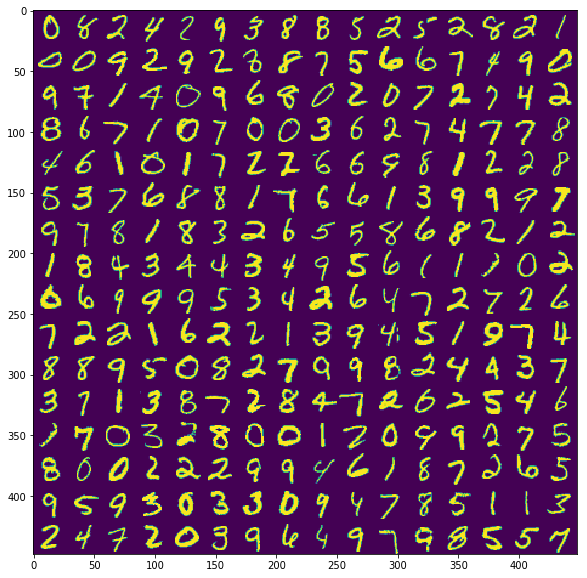

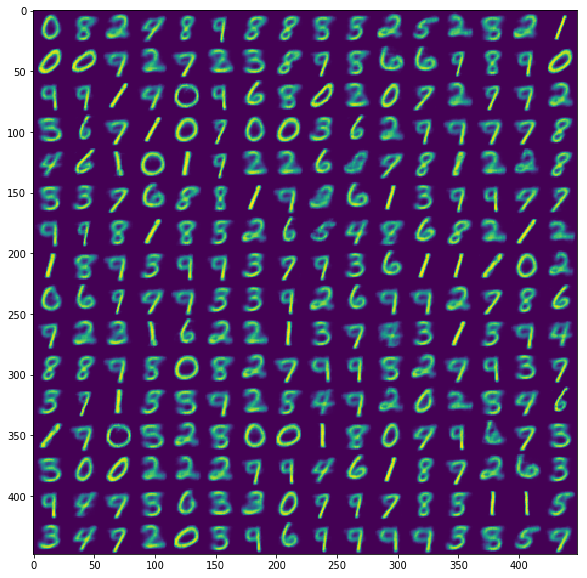

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(X_sample.reshape(16, 16, 28, 28).transpose(0, 2, 1, 3).reshape(16*28, 16*28))

plt.figure(figsize=(10,10))
plt.imshow(recon_viz.reshape(16, 16, 28, 28).transpose(0, 2, 1, 3).reshape(16*28, 16*28))

# Visualize the latent space (AE)

In [10]:
Z_test, = session.run([Z], feed_dict={X: X_test[:, :, :, np.newaxis]})

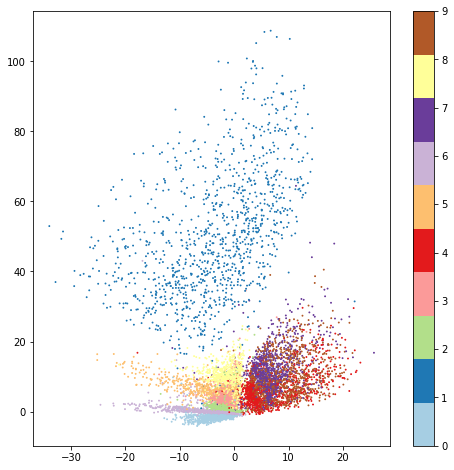

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(*Z_test.T, 0.8, c=Y_test, cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar()

In [6]:
def reparameterize(Z_mu, Z_logvar):
    # Return a sample from a Gaussian distribution with mean "mu" and diagonal log-variance "logvar"
    # Note: logvar is not a full covariance matrix,
    # but a vector whose values correspond to the diagonal of the covariance matrix.
    
    Z_std = tf.exp(Z_logvar/2)
    eps = tf.random.normal(shape=tf.shape(Z_mu))
    
    # Return a sample from Z
    Z_sample = Z_mu + eps*Z_std
    return Z_sample

def kld_loss(Z_mu, Z_logvar):
    # Return the KL divergence between Z and a Gaussian prior N(0, I)
    kld = -0.5 * tf.reduce_sum(1 + Z_logvar - Z_mu**2 - tf.exp(Z_logvar), axis=1)
    
    # Average across batch dimension
    return tf.reduce_mean(kld, axis=0)

In [7]:
tf.reset_default_graph()

X, Z_mu, Z_logvar = construct_encoder(variational=True)
Z = reparameterize(Z_mu, Z_logvar)
X_recon = construct_decoder(Z)

bce_loss = log_likelihood_loss(X_recon, X)
kld = kld_loss(Z_mu, Z_logvar)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(bce_loss + kld)

init = tf.global_variables_initializer()

In [8]:
session = tf.Session()
session.run(init)

batch_size = 256

# Summary for TensorBoard
summary_writer = tf.summary.FileWriter('ex09/vae', session.graph)
tf.summary.scalar(name='bce_loss', tensor=bce_loss)
tf.summary.scalar(name='kld_loss', tensor=kld)
summary_op = tf.summary.merge_all()

iteration = 0
for epoch in range(50):
    perm_indices = np.random.permutation(X_train.shape[0])
    
    index = 0
    
    total_loss = 0
    total_kld = 0
    N_batches = 0
    while index < X_train.shape[0]:
        X_batch = X_train[index:index+batch_size]
        index += batch_size
        
        _, loss_value, kld_value, summary_str = session.run([train_op, bce_loss, kld, summary_op],
                                                  feed_dict={X: X_batch[:, :, :, np.newaxis]})
        summary_writer.add_summary(summary_str, iteration)
        
        total_loss += loss_value
        total_kld += kld_value
        N_batches += 1
        iteration += 1
        
    total_loss /= N_batches
    total_kld /= N_batches
    
    print('[Epoch {}] bce_loss: {} - kld_loss: {}'.format(epoch+1, total_loss, total_kld))

[Epoch 1] bce_loss: 230.6228053316157 - kld_loss: 3.155572667278032
[Epoch 2] bce_loss: 176.15035880880154 - kld_loss: 3.900112756769708
[Epoch 3] bce_loss: 169.05761244753575 - kld_loss: 4.408428521866494
[Epoch 4] bce_loss: 165.17294415413065 - kld_loss: 4.613907063260991
[Epoch 5] bce_loss: 162.9342183863863 - kld_loss: 4.755296926295504
[Epoch 6] bce_loss: 161.17686059830038 - kld_loss: 4.896184324710927
[Epoch 7] bce_loss: 159.678417903819 - kld_loss: 5.007401559707966
[Epoch 8] bce_loss: 158.19849243164063 - kld_loss: 5.1325312715895635
[Epoch 9] bce_loss: 156.84123301404588 - kld_loss: 5.218775051198107
[Epoch 10] bce_loss: 155.508274419257 - kld_loss: 5.309393271994083
[Epoch 11] bce_loss: 154.50348205566405 - kld_loss: 5.408464934978079
[Epoch 12] bce_loss: 153.54332119556184 - kld_loss: 5.46890609010737
[Epoch 13] bce_loss: 152.4892758633228 - kld_loss: 5.5632145272924545
[Epoch 14] bce_loss: 151.81373063757064 - kld_loss: 5.596706895625338
[Epoch 15] bce_loss: 150.9962664665

# Sample reconstruction from the test set (VAE)

In [15]:
X_sample = X_test[np.random.choice(X_test.shape[0], size=16*16)]
recon_viz, = session.run([tf.sigmoid(X_recon)], feed_dict={X: X_sample[:, :, :, np.newaxis]})

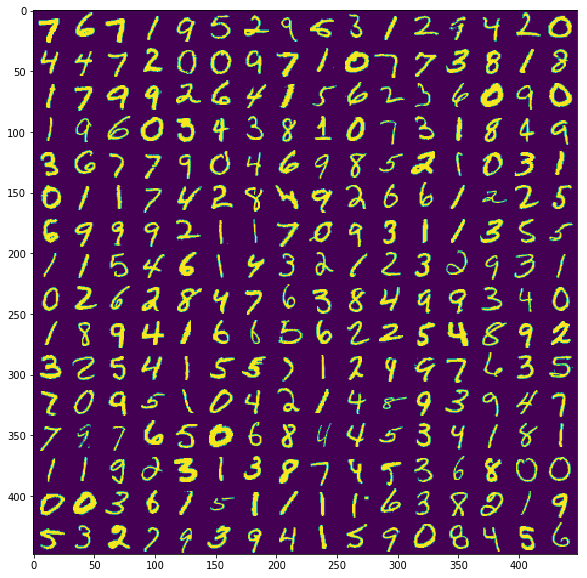

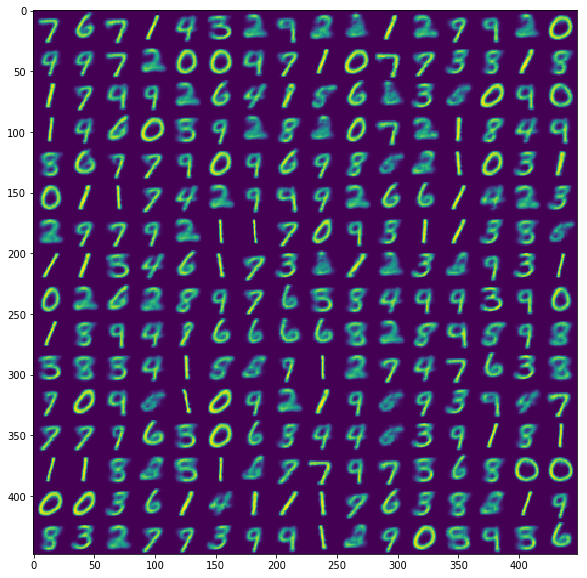

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(X_sample.reshape(16, 16, 28, 28).transpose(0, 2, 1, 3).reshape(16*28, 16*28))

plt.figure(figsize=(10,10))
plt.imshow(recon_viz.reshape(16, 16, 28, 28).transpose(0, 2, 1, 3).reshape(16*28, 16*28))

# Visualize the latent space (VAE)
This code features an interactive visualization of the generated digits as you move the mouse across the latent space.

In [9]:
Z_test, = session.run([Z], feed_dict={X: X_test[:, :, :, np.newaxis]})

<IPython.core.display.Javascript object>


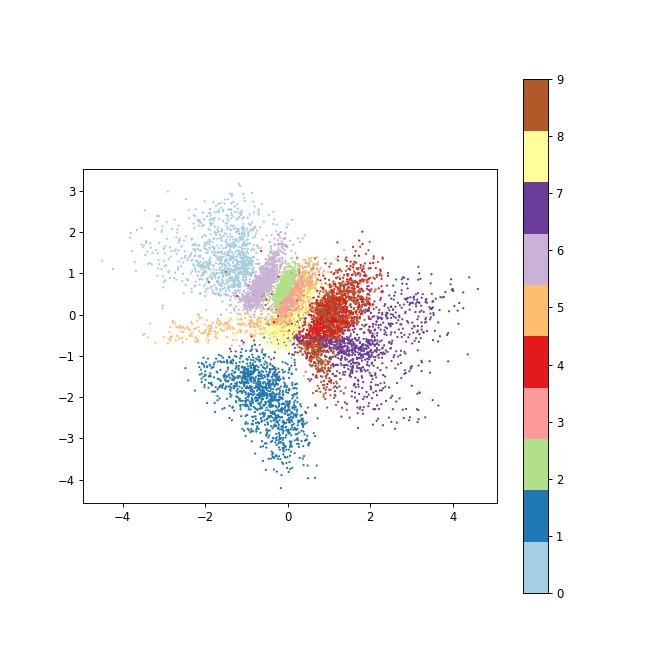

<IPython.core.display.Javascript object>


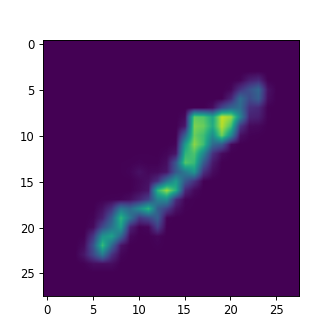

In [10]:
%matplotlib notebook
rendered_digit = np.zeros((28, 28))

plt.figure(figsize=(8, 8))
plt.scatter(*Z_test.T, 0.8, c=Y_test, cmap=plt.cm.get_cmap('Paired', 10))
plt.gca().set_aspect('equal')
plt.colorbar()
def mouse_move(event):
    global digit
    
    if event.xdata is not None:
        embedding = np.array([[event.xdata, event.ydata]], dtype='float32')
        
        # Inject value into graph
        rendered_digit, = session.run([tf.sigmoid(X_recon)], feed_dict={Z: embedding})
        rendered_digit = rendered_digit.reshape(28, 28)
        digit.set_data(rendered_digit)
    
plt.connect('motion_notify_event', mouse_move)
plt.show()

plt.figure(figsize=(4, 4))
digit = plt.imshow(rendered_digit, vmin=0, vmax=1, interpolation='bilinear')

# Sample from the generative model

In [17]:
Z_sample = np.random.normal(size=(16*16, 2))
recon_viz, = session.run([tf.sigmoid(X_recon)], feed_dict={Z: Z_sample})

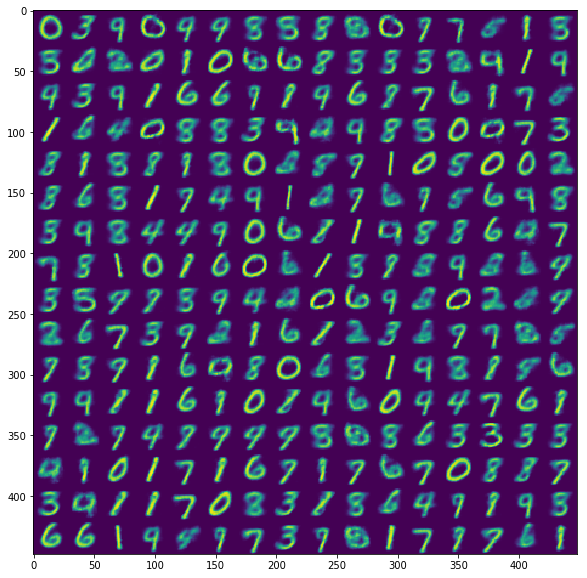

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(recon_viz.reshape(16, 16, 28, 28).transpose(0, 2, 1, 3).reshape(16*28, 16*28))